In [1]:
import os
import gc
import sys
import time

import pyreadr as py
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from collections import defaultdict

import torch
import torch.nn.functional as F

from torch import nn
from torch.optim import Adam, RMSprop
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from datetime import datetime

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda:1


> ### Data downloading
Data link  
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/6C3JR1

##### Data description
Here we consoder dataset of "Additional Tennessee Eastman Process Simulation Data for Anomaly Detection Evaluation"
This dataverse contains the data referenced in Rieth et al. (2017). Issues and Advances in Anomaly Detection Evaluation for Joint Human-Automated Systems. To be presented at Applied Human Factors and Ergonomics 2017.
##### Columns description
* **faultNumber** ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).
* **simulationRun** ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).
* **sample** ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.
* **columns 4-55** contain the process variables; the column names retain the original variable names.

In [2]:
# ! unzip ../../data/raw/dataverse_files.zip -d ../../data/raw/dataverse_files

In [3]:
#reading train data in .R format
a1 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Training.RData")
a2 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Training.RData")

In [4]:
print("Objects that are present in a1 :", a1.keys())
print("Objects that are present in a2 :", a2.keys())
# print("Objects that are present in a3 :", a3.keys())
# print("Objects that are present in a4 :", a4.keys())

Objects that are present in a1 : odict_keys(['fault_free_training'])
Objects that are present in a2 : odict_keys(['faulty_training'])


In [5]:
# concatinating the train and the test dataset

raw_train = pd.concat([a1['fault_free_training'], a2['faulty_training']])

In [6]:
# 5.250.000, 10.080.000
len(raw_train)

5250000

> ### Train-test-split

In [7]:
features = [
        'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8',
        'xmeas_9', 'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 
        'xmeas_17', 'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 
        'xmeas_25', 'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32',
        'xmeas_33', 'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 
        'xmeas_41', 'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 
        'xmv_10', 'xmv_11'
    ]

In [8]:
raw_train['index'] = raw_train['faultNumber'] * 500 + raw_train['simulationRun'] - 1

In [9]:
simulation_idx = raw_train[['index', 'faultNumber']].drop_duplicates()

X_train_idx, X_val_idx = train_test_split(simulation_idx['index'], 
                                          stratify=simulation_idx['faultNumber'],
                                          test_size=0.2, 
                                          random_state=42)

In [10]:
X_train = raw_train[raw_train['index'].isin(X_train_idx)].drop('index', axis=1)
X_val = raw_train[raw_train['index'].isin(X_val_idx)].drop('index', axis=1)

> ### Scaling

In [11]:
scaler = StandardScaler()
scaler.fit(X_train[features])

X_train[features] = scaler.transform(X_train[features])
X_val[features] = scaler.transform(X_val[features])

> ### Dataset and dataloader

In [12]:
def correct(y_pred, target):
    
    y_pred = torch.softmax(y_pred, dim=1)
    y_pred = torch.max(y_pred, dim=1)[1]  
    
    return torch.eq(y_pred, target).sum().item()

In [13]:
FAULT_START_TRAINVAL = 20
FAULT_START_TEST = 160

In [14]:
class DataTEP(Dataset):

    def __init__(self, X):
    
        self.X = X
        self.X = self.X.sort_values(['faultNumber', 'simulationRun', 'sample'])
        self.X['index'] = self.X.groupby(['faultNumber', 'simulationRun']).ngroup()
        self.X = self.X.set_index('index')
        
        self.max_length = self.X['sample'].max()

        self.s_list = [FAULT_START_TRAINVAL, FAULT_START_TRAINVAL + 200]
        self.l_list = [200]
        
#         self.s_list = [FAULT_START_TRAINVAL]
#         self.l_list = [50, 100]
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique() * len(self.s_list) * len(self.l_list)
    
    def __getitem__(self, idx):
        
        fault_sim_idx = idx // (len(self.s_list) * len(self.l_list))
    
        start_length_idxs = idx % (len(self.s_list) * len(self.l_list))
        
        start_idx = self.s_list[start_length_idxs // len(self.l_list)]
        seq_length = self.l_list[start_length_idxs % len(self.l_list)]

        features = self.X.loc[fault_sim_idx][self.features].values[start_idx : (start_idx+seq_length), :]
        target = self.X.loc[fault_sim_idx]['faultNumber'].unique()[0]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [15]:
BATCH_SIZE = 64
NUM_CLASSES = 21

In [16]:
def collate_fn(batch):

    sequences = [x[0] for x in batch]
    labels = [x[1] for x in batch]
        
    lengths = torch.LongTensor([len(x) for x in sequences])
    lengths, idx = lengths.sort(0, descending=True)
    
    sequences = [sequences[i] for i in idx]
    
    labels = torch.tensor(labels, dtype=torch.long)[idx]
    
    sequences_padded = pad_sequence(sequences, batch_first=True)

    return sequences_padded, lengths, labels

In [17]:
train_ds = DataTEP(X_train)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)

val_ds = DataTEP(X_val)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE*4, collate_fn=collate_fn)

In [18]:
train_ds[1000][1]

tensor(1)

In [19]:
len(train_ds), len(val_ds)

(16800, 4200)

In [20]:
gc.collect()

0

> ### Models

In [21]:
class UniRNN(nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type,
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional,
            "DESCRIPTION": self.description,
            }
            
    def forward(self, x, x_length):
        
        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        x_rnn_out, _ = self.rnn(x_packed)
        x_unpacked, _ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        idx_last_hidden = (x_length - 1).view(-1, 1).expand(len(x_length), x_unpacked.size(2)).unsqueeze(1)
        idx_last_hidden = idx_last_hidden.to(x.device)
        x_last_hiddens = x_unpacked.gather(1, idx_last_hidden).squeeze(1)
        
        x = self.head(x_last_hiddens)
        
        return x

In [22]:
class AttentionModel(torch.nn.Module):
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL):
        super().__init__()
        
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        rnn_cell = getattr(nn, RNN_TYPE)

        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size, 
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        dropout=0.4,
                        batch_first=True
                )
        
        self.head = nn.Sequential(
#                         nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.output_size),
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
        
        
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type, 
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional
        }
    

    def attention(self, lstm_output, last_hidden):
        
        attn_weights = torch.bmm(lstm_output, last_hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, dim=1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)

        return new_hidden_state
    
    def forward(self, x, x_length):

        x_packed = pack_padded_sequence(x, x_length, batch_first=True)
        
        x_rnn_out, _ = self.rnn(x_packed)
        
        x_unpacked, __ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        idx_last_hidden = (x_length - 1).view(-1, 1).expand(len(x_length), x_unpacked.size(2)).unsqueeze(1)
        idx_last_hidden = idx_last_hidden.to(x.device)
        x_last_hiddens = x_unpacked.gather(1, idx_last_hidden).squeeze(1)
        
        attention_out = self.attention(x_unpacked, x_last_hiddens)
        x = self.head(attention_out)

        return x

In [23]:
class TransformerModel(torch.nn.Module):
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, DROPOUT):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.dropout = DROPOUT
        
        transformer_encoder_layer = nn.TransformerEncoderLayer(
                        d_model=self.input_size, 
                        nhead=4, 
                        dim_feedforward=self.hidden_size, 
                        dropout=self.dropout, 
                        activation='relu'
                )
        
        
        self.transformer_encoder = nn.TransformerEncoder(
                        encoder_layer=transformer_encoder_layer, 
                        num_layers=self.num_layers, 
                        norm=None
                )
        
        self.weighted_mean = nn.Conv1d(
                        in_channels=self.input_size, 
                        out_channels=self.input_size, 
                        kernel_size=100, 
                        groups=self.input_size)
    
        self.head = nn.Sequential(
                        nn.Dropout(p=0.2),
                        nn.Linear(in_features=52, out_features=self.output_size),
#                         nn.Linear(in_features=52, out_features=self.linear_size),
#                         nn.ReLU(),
#                         nn.Dropout(p=0.4),
#                         nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
        
    
    def get_params(self):
        
        return {
                "HIDDEN_SIZE": self.hidden_size,
                "NUM_LAYERS": self.num_layers,
                "INPUT_SIZE": self.input_size,
                "LINEAR_SIZE": self.linear_size,
                "OUTPUT_SIZE": self.output_size,
                "DROPOUT": self.dropout
            }    
    
    
    def forward(self, x, x_length=None):
        """
        src: (S, N, E) = (sequence_length, batch_size, n_features)
        src_key_padding_mask: (N, S) = (batch_size, sequence_length)
        """
    
        x_mask = torch.zeros(x.size(0), x.size(1), dtype=bool, device=x.device)
        
        for i in range(len(x)):
            x_mask[i, x_length[i]:] = True

        x = self.transformer_encoder(src=x.transpose(0, 1), src_key_padding_mask=x_mask)
        x = x.permute(1, 2, 0)
        x = self.weighted_mean(x)
        x = x.squeeze(-1)
        x = self.head(x)

        return x

In [24]:
class MultiRNN(nn.Module) :
    def __init__(self, RNN_TYPE, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DESCRIPTION):
        super().__init__()
        
        self.rnn_type = RNN_TYPE
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        self.description = DESCRIPTION
        
        rnn_cell = getattr(nn, RNN_TYPE)
        
        self.rnn = rnn_cell(
                        input_size=self.input_size, 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
                )    
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=self.output_size),
                )
    
    def get_params(self):
        
        return {
            "RNN_TYPE": self.rnn_type,
            "HIDDEN_SIZE": self.hidden_size,
            "NUM_LAYERS": self.num_layers,
            "INPUT_SIZE": self.input_size,
            "LINEAR_SIZE": self.linear_size,
            "OUTPUT_SIZE": self.output_size,
            "BIDIRECTIONAL": self.bidirectional,
            "DESCRIPTION": self.description,
            }
            
    def forward(self, x, x_length):
        
#         print("x", x.size())
        x, _ = self.rnn(x)
#         print("x", x.size())
        x = self.head(x)
#         print("x", x.size())
        
        return x

In [66]:
NUM_EPOCHS = 50
LEARNING_RATE = 0.001

NUM_LAYERS = 2
HIDDEN_SIZE = 128
LINEAR_SIZE = 64
BIDIRECTIONAL = False

RNN_TYPE = "LSTM"

> ### Model initialization

In [67]:
torch.manual_seed(42)
np.random.seed(42)


# model = UniRNN(
#             RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
#             LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, 
#             DESCRIPTION='simple_model_for_metrics'
#         )

# model = AttentionModel(
#             RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
#             LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL
#         )

# model = TransformerModel(
#             NUM_LAYERS=6, INPUT_SIZE=52, HIDDEN_SIZE=128, LINEAR_SIZE=52, OUTPUT_SIZE=21, DROPOUT=0.4
#         )

model = MultiRNN(
            RNN_TYPE=RNN_TYPE, NUM_LAYERS=NUM_LAYERS, INPUT_SIZE=52, HIDDEN_SIZE=HIDDEN_SIZE, 
            LINEAR_SIZE=LINEAR_SIZE, OUTPUT_SIZE=NUM_CLASSES, BIDIRECTIONAL=BIDIRECTIONAL, 
            DESCRIPTION='simple_model_for_metrics'
        )

model = model.to(device)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
# scheduler = StepLR(optimizer, step_size=25, gamma=0.5)
scheduler = ReduceLROnPlateau(optimizer, patience=10, verbose=True)

In [68]:
for i, (X_batch, X_lengths, y_batch) in enumerate(train_dl):
    if i < 1:
        print(type(X_batch), type(X_lengths), type(y_batch))
        print(len(X_batch), len(X_lengths), len(y_batch))
        print(X_lengths)
        X_batch, y_batch_train = X_batch.to(device), y_batch.to(device)
        y_pred_train = model(X_batch, X_lengths)
        print("y_batch_train.size()", y_batch.size())
        print("y_pred_train.size()", y_pred_train.size(), '\n')
    else:
        break

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
64 64 64
tensor([200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,
        200, 200, 200, 200, 200, 200, 200, 200])
y_batch_train.size() torch.Size([64])
y_pred_train.size() torch.Size([64, 200, 21]) 



In [69]:
model_name = f"final_models/multi_rnn/{RNN_TYPE}_{datetime.today().strftime('%d%b-%H-%M')}"

writer = SummaryWriter(log_dir=model_name)

In [71]:
ls final_models/multi_rnn

GRU_22May-14-35/  LSTM_22May-16-20/


> ### Training

In [72]:
loss_train_all, loss_val_all = [], []
accuracy_train_all, accuracy_val_all = [], []

best_model_acc = 0
best_model_epoch = 0

for epoch in range(NUM_EPOCHS):

    start = time.time()
    print(f"Epoch: {epoch}, Learning Rate: {optimizer.param_groups[0]['lr']}\n")

    loss_train_epoch, loss_val_epoch = 0, 0
    correct_train_epoch, correct_val_epoch = 0, 0
    n_train, n_val = 0, 0

    model.train()
    for (X_batch_train, X_batch_lengths_train, y_batch_train) in tqdm(train_dl):

        X_batch_train, X_batch_lengths_train, y_batch_train =\
                    X_batch_train.to(device), X_batch_lengths_train.to(device), y_batch_train.to(device)

        optimizer.zero_grad()
        y_pred_train = model(X_batch_train, X_batch_lengths_train)
        
        y_pred_train = y_pred_train.permute(0, 2, 1)
        y_batch_train = y_batch_train.repeat(200, 1).transpose(1, 0)
        
        loss_train = criterion(y_pred_train, y_batch_train)
        loss_train.backward()
        optimizer.step()

        loss_train_epoch += loss_train.item() * y_batch_train.size(0) * y_batch_train.size(1)
        correct_train_epoch += correct(y_pred_train, y_batch_train)
        n_train += y_batch_train.size(0) * y_batch_train.size(1)

#     scheduler.step()
    model.eval()

    with torch.no_grad():
        
        for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

            X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

            y_pred_val = model(X_batch_val, X_batch_lengths_val)             

            y_pred_val = y_pred_val.permute(0, 2, 1)
            y_batch_val = y_batch_val.repeat(200, 1).transpose(1, 0)
        
            loss_val = criterion(y_pred_val, y_batch_val)
            
            loss_val_epoch += loss_val.item() * y_batch_val.size(0) * y_batch_val.size(1)
            correct_val_epoch += correct(y_pred_val, y_batch_val)
            n_val += y_batch_val.size(0)*y_batch_val.size(1)
            
    loss_mean_train_epoch = loss_train_epoch / n_train
    loss_mean_val_epoch = loss_val_epoch / n_val

    loss_train_all.append(loss_mean_train_epoch)
    loss_val_all.append(loss_mean_val_epoch)

    accuracy_train_epoch = correct_train_epoch / n_train
    accuracy_val_epoch = correct_val_epoch / n_val

    accuracy_train_all.append(accuracy_train_epoch)
    accuracy_val_all.append(accuracy_val_epoch)

    writer.add_scalars('LOSS per epoch', {"train": loss_mean_train_epoch, "val": loss_mean_val_epoch}, epoch)
    writer.add_scalars('ACCURACY per epoch', {"train": accuracy_train_epoch, "val": accuracy_val_epoch}, epoch)
    
    if accuracy_val_epoch > best_model_acc:
        
        best_model_state_dict = model.state_dict()
        best_model_acc = accuracy_val_epoch
        best_model_epoch = epoch
        
    scheduler.step(loss_mean_val_epoch)
    
    end = time.time()
    print(f"epoch time: {end - start}")  
    print(f"mean loss train: {loss_mean_train_epoch}, mean loss val: {loss_mean_val_epoch}")
    print(f"accuracy train: {accuracy_train_epoch}, accuracy val: {accuracy_val_epoch}")

    print("---------------------------------------------------------------------------------------------------")

Epoch: 0, Learning Rate: 0.001




epoch time: 48.87264156341553
mean loss train: 1.6199040079116822, mean loss val: 0.9468918974058969
accuracy train: 0.48680089285714284, accuracy val: 0.6786880952380953
---------------------------------------------------------------------------------------------------
Epoch: 1, Learning Rate: 0.001




epoch time: 49.019185304641724
mean loss train: 0.8056424019450233, mean loss val: 0.7568531698272342
accuracy train: 0.7149354166666667, accuracy val: 0.719525
---------------------------------------------------------------------------------------------------
Epoch: 2, Learning Rate: 0.001




epoch time: 49.977705240249634
mean loss train: 0.6755111035846528, mean loss val: 0.5663438517139071
accuracy train: 0.7397901785714286, accuracy val: 0.7615273809523809
---------------------------------------------------------------------------------------------------
Epoch: 3, Learning Rate: 0.001




epoch time: 48.305060148239136
mean loss train: 0.5647072063173566, mean loss val: 0.5148731274264199
accuracy train: 0.7636836309523809, accuracy val: 0.774477380952381
---------------------------------------------------------------------------------------------------
Epoch: 4, Learning Rate: 0.001




epoch time: 49.55528974533081
mean loss train: 0.5199854958625066, mean loss val: 0.4708360547111148
accuracy train: 0.780046130952381, accuracy val: 0.7977119047619048
---------------------------------------------------------------------------------------------------
Epoch: 5, Learning Rate: 0.001




epoch time: 47.01287531852722
mean loss train: 0.4843836192857651, mean loss val: 0.48794391427721295
accuracy train: 0.8033020833333333, accuracy val: 0.8097321428571429
---------------------------------------------------------------------------------------------------
Epoch: 6, Learning Rate: 0.001




epoch time: 49.334933280944824
mean loss train: 0.4686488379750933, mean loss val: 0.4655753043152037
accuracy train: 0.8124961309523809, accuracy val: 0.8133202380952381
---------------------------------------------------------------------------------------------------
Epoch: 7, Learning Rate: 0.001




epoch time: 48.60916042327881
mean loss train: 0.4675760072753543, mean loss val: 0.42355900523208434
accuracy train: 0.814535119047619, accuracy val: 0.8274547619047619
---------------------------------------------------------------------------------------------------
Epoch: 8, Learning Rate: 0.001




epoch time: 50.43919634819031
mean loss train: 0.4181457328796387, mean loss val: 0.422296372680437
accuracy train: 0.8323416666666666, accuracy val: 0.8233892857142857
---------------------------------------------------------------------------------------------------
Epoch: 9, Learning Rate: 0.001




epoch time: 48.99177289009094
mean loss train: 0.399426653668994, mean loss val: 0.3682891489210583
accuracy train: 0.8404738095238096, accuracy val: 0.8497738095238095
---------------------------------------------------------------------------------------------------
Epoch: 10, Learning Rate: 0.001




epoch time: 49.779579401016235
mean loss train: 0.4348139192376818, mean loss val: 0.34240558848494573
accuracy train: 0.8322366071428572, accuracy val: 0.8622392857142858
---------------------------------------------------------------------------------------------------
Epoch: 11, Learning Rate: 0.001




epoch time: 47.13300561904907
mean loss train: 0.36715004109200977, mean loss val: 0.32218367590790703
accuracy train: 0.8528056547619047, accuracy val: 0.868027380952381
---------------------------------------------------------------------------------------------------
Epoch: 12, Learning Rate: 0.001




epoch time: 48.30478000640869
mean loss train: 0.39012463495844885, mean loss val: 0.42816887145950683
accuracy train: 0.8481223214285715, accuracy val: 0.8314714285714285
---------------------------------------------------------------------------------------------------
Epoch: 13, Learning Rate: 0.001




epoch time: 51.678171157836914
mean loss train: 0.34265819311141965, mean loss val: 0.3128539412362235
accuracy train: 0.8624738095238095, accuracy val: 0.8705988095238095
---------------------------------------------------------------------------------------------------
Epoch: 14, Learning Rate: 0.001




epoch time: 49.68818664550781
mean loss train: 0.32410357407161167, mean loss val: 0.27642578218664443
accuracy train: 0.8725032738095239, accuracy val: 0.893175
---------------------------------------------------------------------------------------------------
Epoch: 15, Learning Rate: 0.001




epoch time: 49.44581484794617
mean loss train: 0.29476667111828214, mean loss val: 0.24846824471439635
accuracy train: 0.8880470238095238, accuracy val: 0.9006773809523809
---------------------------------------------------------------------------------------------------
Epoch: 16, Learning Rate: 0.001




epoch time: 49.078192949295044
mean loss train: 0.2661104403507142, mean loss val: 0.25350836389121556
accuracy train: 0.8963880952380953, accuracy val: 0.899127380952381
---------------------------------------------------------------------------------------------------
Epoch: 17, Learning Rate: 0.001




epoch time: 49.55753946304321
mean loss train: 0.249926166392508, mean loss val: 0.2328234398223105
accuracy train: 0.8998931547619048, accuracy val: 0.9063571428571429
---------------------------------------------------------------------------------------------------
Epoch: 18, Learning Rate: 0.001




epoch time: 48.61086320877075
mean loss train: 0.28190188277335393, mean loss val: 0.286249606013298
accuracy train: 0.8912842261904762, accuracy val: 0.8982797619047619
---------------------------------------------------------------------------------------------------
Epoch: 19, Learning Rate: 0.001




epoch time: 50.09056377410889
mean loss train: 0.2629505890040171, mean loss val: 0.23164836294594265
accuracy train: 0.8959544642857142, accuracy val: 0.9057130952380953
---------------------------------------------------------------------------------------------------
Epoch: 20, Learning Rate: 0.001




epoch time: 49.455329179763794
mean loss train: 0.22725154008184162, mean loss val: 0.2132635806146122
accuracy train: 0.9070511904761904, accuracy val: 0.9091714285714285
---------------------------------------------------------------------------------------------------
Epoch: 21, Learning Rate: 0.001




epoch time: 49.41753888130188
mean loss train: 0.22149655654316858, mean loss val: 0.20975637763738633
accuracy train: 0.9073473214285714, accuracy val: 0.9110952380952381
---------------------------------------------------------------------------------------------------
Epoch: 22, Learning Rate: 0.001




epoch time: 48.00096821784973
mean loss train: 0.2183147607814698, mean loss val: 0.20632156078304564
accuracy train: 0.9080458333333333, accuracy val: 0.9131642857142858
---------------------------------------------------------------------------------------------------
Epoch: 23, Learning Rate: 0.001




epoch time: 49.07008481025696
mean loss train: 0.22170355876286824, mean loss val: 0.23617363305318922
accuracy train: 0.9077577380952381, accuracy val: 0.905602380952381
---------------------------------------------------------------------------------------------------
Epoch: 24, Learning Rate: 0.001




epoch time: 50.132319927215576
mean loss train: 0.22066072943664733, mean loss val: 0.2057374105389629
accuracy train: 0.9084139880952381, accuracy val: 0.9135869047619047
---------------------------------------------------------------------------------------------------
Epoch: 25, Learning Rate: 0.001




epoch time: 49.5745062828064
mean loss train: 0.2179628147965386, mean loss val: 0.20596605479362465
accuracy train: 0.908963988095238, accuracy val: 0.9133190476190476
---------------------------------------------------------------------------------------------------
Epoch: 26, Learning Rate: 0.001




epoch time: 48.614089012145996
mean loss train: 0.21025521885781062, mean loss val: 0.19840037763828322
accuracy train: 0.9116196428571428, accuracy val: 0.9136857142857143
---------------------------------------------------------------------------------------------------
Epoch: 27, Learning Rate: 0.001




epoch time: 49.478493213653564
mean loss train: 0.22272034352733974, mean loss val: 0.19746340927623568
accuracy train: 0.9073449404761905, accuracy val: 0.9136571428571428
---------------------------------------------------------------------------------------------------
Epoch: 28, Learning Rate: 0.001




epoch time: 48.38213014602661
mean loss train: 0.20409124584425065, mean loss val: 0.2390009901495207
accuracy train: 0.9123482142857143, accuracy val: 0.9041869047619048
---------------------------------------------------------------------------------------------------
Epoch: 29, Learning Rate: 0.001




epoch time: 49.610968828201294
mean loss train: 0.20758522984527406, mean loss val: 0.19915894658969982
accuracy train: 0.9115967261904762, accuracy val: 0.9133119047619047
---------------------------------------------------------------------------------------------------
Epoch: 30, Learning Rate: 0.001




epoch time: 48.70040941238403
mean loss train: 0.19834852967943464, mean loss val: 0.19146145342538753
accuracy train: 0.914222619047619, accuracy val: 0.9178738095238095
---------------------------------------------------------------------------------------------------
Epoch: 31, Learning Rate: 0.001




epoch time: 51.045780658721924
mean loss train: 0.2104732025521142, mean loss val: 0.2026571589779286
accuracy train: 0.9127372023809524, accuracy val: 0.913275
---------------------------------------------------------------------------------------------------
Epoch: 32, Learning Rate: 0.001




epoch time: 49.08487677574158
mean loss train: 0.20296378984337762, mean loss val: 0.19959191989685807
accuracy train: 0.9144958333333333, accuracy val: 0.9215023809523809
---------------------------------------------------------------------------------------------------
Epoch: 33, Learning Rate: 0.001




epoch time: 47.57424235343933
mean loss train: 0.19502883772055307, mean loss val: 0.18974605520211515
accuracy train: 0.9175571428571428, accuracy val: 0.9255285714285715
---------------------------------------------------------------------------------------------------
Epoch: 34, Learning Rate: 0.001




epoch time: 46.738656520843506
mean loss train: 0.21404063718659538, mean loss val: 0.2140450553613759
accuracy train: 0.9152127976190476, accuracy val: 0.9131797619047619
---------------------------------------------------------------------------------------------------
Epoch: 35, Learning Rate: 0.001




epoch time: 48.96177625656128
mean loss train: 0.19836849536214557, mean loss val: 0.19080463842444476
accuracy train: 0.9206839285714286, accuracy val: 0.9195630952380952
---------------------------------------------------------------------------------------------------
Epoch: 36, Learning Rate: 0.001




epoch time: 51.11779046058655
mean loss train: 0.20652996014981043, mean loss val: 0.18931694881990552
accuracy train: 0.9190955357142857, accuracy val: 0.9257357142857143
---------------------------------------------------------------------------------------------------
Epoch: 37, Learning Rate: 0.001




epoch time: 50.064568281173706
mean loss train: 0.1917050544420878, mean loss val: 0.1914082178420254
accuracy train: 0.9241035714285715, accuracy val: 0.9213369047619048
---------------------------------------------------------------------------------------------------
Epoch: 38, Learning Rate: 0.001




epoch time: 49.458967208862305
mean loss train: 0.21310163656870523, mean loss val: 0.19433664087206126
accuracy train: 0.9189794642857143, accuracy val: 0.922947619047619
---------------------------------------------------------------------------------------------------
Epoch: 39, Learning Rate: 0.001




epoch time: 50.7162606716156
mean loss train: 0.18939830425239745, mean loss val: 0.19145581693876357
accuracy train: 0.9270568452380953, accuracy val: 0.9192642857142858
---------------------------------------------------------------------------------------------------
Epoch: 40, Learning Rate: 0.001




epoch time: 48.704803228378296
mean loss train: 0.18141221134435562, mean loss val: 0.22005125081964902
accuracy train: 0.9292625, accuracy val: 0.9163607142857143
---------------------------------------------------------------------------------------------------
Epoch: 41, Learning Rate: 0.001




epoch time: 49.68700098991394
mean loss train: 0.19323969798428672, mean loss val: 0.19904496947569505
accuracy train: 0.9259788690476191, accuracy val: 0.9237309523809524
---------------------------------------------------------------------------------------------------
Epoch: 42, Learning Rate: 0.001




epoch time: 49.47425937652588
mean loss train: 0.18737399827866327, mean loss val: 0.1787309062534145
accuracy train: 0.9290345238095238, accuracy val: 0.9302452380952381
---------------------------------------------------------------------------------------------------
Epoch: 43, Learning Rate: 0.001




epoch time: 47.78029251098633
mean loss train: 0.1838240803423382, mean loss val: 0.17828823447582268
accuracy train: 0.9317092261904761, accuracy val: 0.9316130952380952
---------------------------------------------------------------------------------------------------
Epoch: 44, Learning Rate: 0.001




epoch time: 49.84391260147095
mean loss train: 0.18042094738710493, mean loss val: 0.1894721972844785
accuracy train: 0.9332297619047619, accuracy val: 0.9256428571428571
---------------------------------------------------------------------------------------------------
Epoch: 45, Learning Rate: 0.001




epoch time: 48.78258919715881
mean loss train: 0.17609975658711932, mean loss val: 0.18821773116875973
accuracy train: 0.9351681547619047, accuracy val: 0.9257452380952381
---------------------------------------------------------------------------------------------------
Epoch: 46, Learning Rate: 0.001




epoch time: 50.463420152664185
mean loss train: 0.16982814530531565, mean loss val: 0.1745721353302222
accuracy train: 0.9365136904761905, accuracy val: 0.9338047619047619
---------------------------------------------------------------------------------------------------
Epoch: 47, Learning Rate: 0.001




epoch time: 48.531333684921265
mean loss train: 0.18100827086539495, mean loss val: 0.1747097697512557
accuracy train: 0.9334839285714286, accuracy val: 0.9331428571428572
---------------------------------------------------------------------------------------------------
Epoch: 48, Learning Rate: 0.001




epoch time: 49.38234519958496
mean loss train: 0.16910879004569282, mean loss val: 0.1748224321539913
accuracy train: 0.9377205357142857, accuracy val: 0.9310095238095238
---------------------------------------------------------------------------------------------------
Epoch: 49, Learning Rate: 0.001




epoch time: 50.48449635505676
mean loss train: 0.16644024113814035, mean loss val: 0.19566246577228108
accuracy train: 0.93985, accuracy val: 0.9250726190476191
---------------------------------------------------------------------------------------------------


In [73]:
writer.add_hparams(model.get_params(), {"best_accuracy": best_model_acc, "best_model_epoch": best_model_epoch})

> ### Loading best model

In [75]:
model_name = model_name.replace("final_models/", '')

In [81]:
model_name

'multi_rnn/LSTM_22May-16-20'

In [78]:
checkpoint = {'model': model.__class__.__name__, 
              'params': model.get_params(),
              'state_dict': best_model_state_dict}

torch.save(checkpoint, f"final_saved_models/{model_name}.pth")

In [80]:
! ls final_saved_models/multi_rnn

GRU_22May-14-35.pth  LSTM_22May-16-20.pth


In [79]:
! ls final_saved_models

multi_rnn


In [82]:
checkpoint = torch.load(f"final_saved_models/{model_name}.pth")

model = getattr(sys.modules[__name__], checkpoint['model'])(**checkpoint['params'])
model.load_state_dict(checkpoint['state_dict'])

for parameter in model.parameters():
        parameter.requires_grad = False
        
model.eval()

MultiRNN(
  (rnn): LSTM(52, 128, num_layers=2, batch_first=True, dropout=0.4)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=64, out_features=21, bias=True)
  )
)

In [83]:
model = model.to(device)

> ### Val evaluation

In [52]:
def get_metrics(y_true, y_pred):
    
    """
    Calculates TPR, FPR and ACCURACY per class for multiple simulation runs
    https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py

    Parameters
    ----------
    y_true : 
        type: np.array 
        shape : (number of simulation runs)
        description: true classes for simulation runs
    
    y_pred : np.array
    
        type: np.array 
        shape : (number of simulation runs)
        description: predicted classes for simulation runs
        
    Returns
    -------
    TPR : 
        type: list of floats
        shape: (number of classes)
        description: True Positive Rate per class
    FPR : 
        type: list of floats
        shape: (number of classes)
        description: False Positive Rate per class
    ACCURACY : 
        type: list of floats
        shape: (number of classes)
        description: Accuracy "one vs all" per class
    """
    
    conf = confusion_matrix(y_true, y_pred)
    
    FP = conf.sum(axis=0) - np.diag(conf)
    FN = conf.sum(axis=1) - np.diag(conf)
    TP = np.diag(conf)
    TN = conf.sum() - (FP + FN + TP)
    
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)

    ACCURACY = (TP + TN) / (TP + TN + FP + FN)
    
    return TPR, FPR, ACCURACY

In [53]:
def get_first_true_idx(arr):
    idx = np.where(arr == True)[0]
    if len(idx) == 0:
        return np.NaN
    else:
        return idx.min()

def get_detection_delay(y_true, y_pred) -> dict():
    """
    Calculates detection delay for every simulation run

    Parameters
    ----------
    y_true : 
        type : np.array 
        shape : (number of simulation runs)
        description : true classes for simulation runs
    
    y_pred : np.array 
        type : np.array 
        shape : (number of simulation runs, simulation runs' lengths)
        description: predicted classes for every sample for every simulation runs
        
    Returns
    -------
    detection_delay :
        type : dict
        keys : classes from 0 to 20
        description : dict of detection delays for every class, nan means true class wasn't predicted
    
    Commentary:
        If you want to get avarage detection delays per class, you need to calulate avg of detection_delay[key]
        for every key 
        
    """
    
    detection_delay = defaultdict(list)
    
    correct = y_pred == y_true[..., np.newaxis]
    first_true_idxs = np.apply_along_axis(func1d=get_first_true_idx, arr=correct, axis=1)

    for (cls, idx) in zip(y_true, first_true_idxs):
        detection_delay[cls].append(idx)
    return detection_delay

In [54]:
model.eval()

y_ans_val, y_true_val = [], []

with torch.no_grad():

    for (X_batch_val, X_batch_lengths_val, y_batch_val) in tqdm(val_dl):

        X_batch_val, X_batch_lengths_val, y_batch_val =\
                    X_batch_val.to(device), X_batch_lengths_val.to(device), y_batch_val.to(device)

        y_pred_val = model(X_batch_val, X_batch_lengths_val)
        
        y_pred_prob = F.softmax(y_pred_val.cpu(), dim=-1)
        y_pred_class = y_pred_prob.max(dim=-1)[1]
       
        y_ans_val += y_pred_class.tolist()
        y_true_val += y_batch_val.tolist()

In [55]:
len(val_ds)

4200

In [56]:
y_ans_val = np.array(y_ans_val)

y_ans_val = y_ans_val[:, -1]

In [57]:
y_true_val = np.array(y_true_val)

In [58]:
# plt.figure(figsize=(20, 8))
# plt.title("loss")
# plt.plot(np.arange(len(loss_train_all)), loss_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(loss_val_all)), loss_val_all, '-o', marker='.', label='val')
# plt.legend()
# plt.show()

In [59]:
# plt.figure(figsize=(20, 8))
# plt.title("accuracy")
# plt.plot(np.arange(len(accuracy_train_all)), accuracy_train_all, '-o', marker='.', label='train')
# plt.plot(np.arange(len(accuracy_val_all)), accuracy_val_all, '-o', marker='.', label='val')
# plt.text(35, 0.65, s=f"best acc: {best_model_acc}\nbest epoch: {best_model_epoch}", fontsize=20)
# plt.scatter(best_model_epoch, best_model_acc, c='g', s=100)
# plt.legend()
# plt.show()

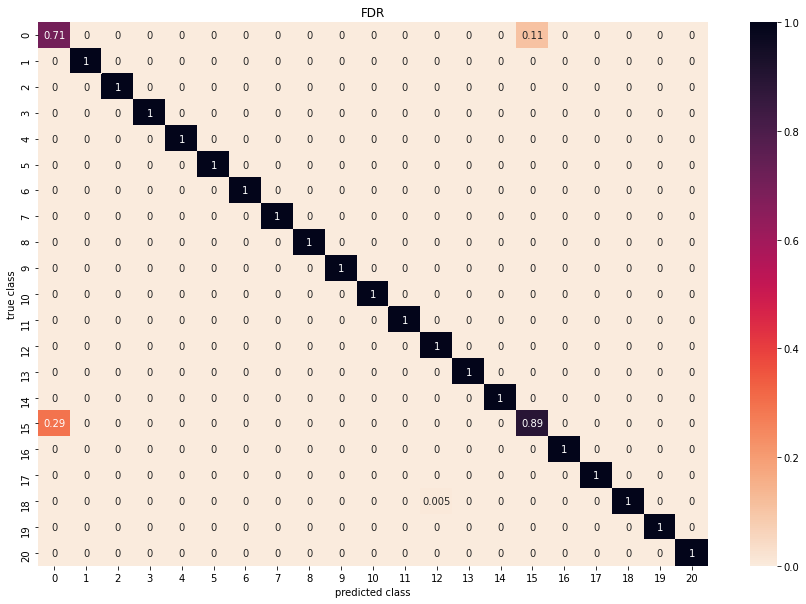

In [60]:
plt.figure(figsize=(15, 10))
plt.title("FDR")
sns.heatmap(confusion_matrix(y_true_val, y_ans_val, normalize='pred'), annot=True, cmap=sns.cm.rocket_r)
plt.xlabel('predicted class')
plt.ylabel('true class')
plt.show()

In [61]:
TPR, FPR, ACCURACY = get_metrics(y_true_val, y_ans_val)

In [62]:
def plotting(arr, name, forward=True):
    classes = np.arange(len(arr))

    norm = plt.Normalize(arr.min(), arr.max())
    
    if forward:
        colors = plt.cm.RdYlGn(norm(arr))
    else:
        colors = plt.cm.summer(norm(arr))
        
    plt.figure(figsize=(8, 5))
    plt.title(f'{name} per class')
#     sns.barplot(x=classes, y=arr, palette=colors)
    plt.plot(arr, '-*', color='yellowgreen')
    plt.xticks(classes, ["fault_" + str(c) if c > 0 else "normal" for c in classes], rotation=90)
    plt.xlabel('class')
    plt.ylabel(f'{name}')
    plt.ylim(0, 1.1)
    plt.show()

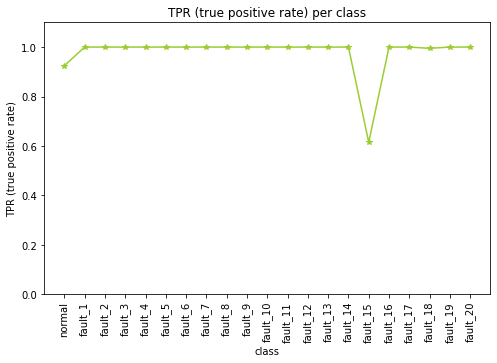

In [63]:
plotting(TPR, "TPR (true positive rate)")

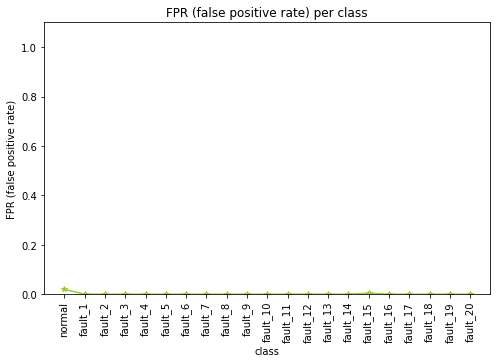

In [64]:
plotting(FPR, "FPR (false positive rate)", forward=False)

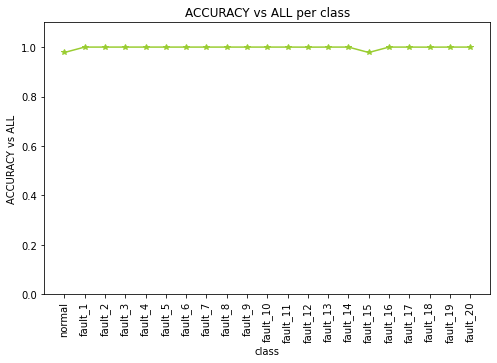

In [65]:
plotting(ACCURACY, "ACCURACY vs ALL")

> ### Test evaluation

In [ ]:
gc.collect()

In [ ]:
#reading test data in .R format
a3 = py.read_r("../../data/raw/dataverse_files/TEP_FaultFree_Testing.RData")
a4 = py.read_r("../../data/raw/dataverse_files/TEP_Faulty_Testing.RData")

raw_test = pd.concat([a3['fault_free_testing'], a4['faulty_testing']])

In [ ]:
raw_test[features] = scaler.transform(raw_test[features])

In [ ]:
raw_test['index'] = raw_test['faultNumber'] * 500 + raw_test['simulationRun'] - 1
raw_test = raw_test.set_index('index')

In [ ]:
raw_test.head()

In [ ]:
class DataTEST(Dataset):

    def __init__(self, X):
    
        self.X = X
        
        self.features = [
                'xmeas_1', 'xmeas_2', 'xmeas_3', 'xmeas_4', 'xmeas_5', 'xmeas_6', 'xmeas_7', 'xmeas_8', 'xmeas_9', 
                'xmeas_10', 'xmeas_11', 'xmeas_12', 'xmeas_13', 'xmeas_14', 'xmeas_15', 'xmeas_16', 'xmeas_17', 
                'xmeas_18', 'xmeas_19', 'xmeas_20', 'xmeas_21', 'xmeas_22', 'xmeas_23', 'xmeas_24', 'xmeas_25', 
                'xmeas_26', 'xmeas_27', 'xmeas_28', 'xmeas_29', 'xmeas_30', 'xmeas_31', 'xmeas_32', 'xmeas_33', 
                'xmeas_34', 'xmeas_35', 'xmeas_36', 'xmeas_37', 'xmeas_38', 'xmeas_39', 'xmeas_40', 'xmeas_41', 
                'xmv_1', 'xmv_2', 'xmv_3', 'xmv_4', 'xmv_5', 'xmv_6', 'xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11'
            ]

    def __len__(self):
        return self.X.index.nunique()
    
    def __getitem__(self, idx):

        features = self.X.loc[idx][self.features].values[FAULT_START_TEST:, :]
        target = self.X.loc[idx]['faultNumber'].values[FAULT_START_TEST:]

        features = torch.tensor(features, dtype=torch.float)
        target = torch.tensor(target, dtype=torch.long)

        return features, target

In [ ]:
test_ds = DataTEST(raw_test)
test_dl = DataLoader(test_ds, batch_size=512)

In [ ]:
%%time

metrics = dict()
y_ans_test_all = []

y_ans_test, y_true_test = [], []

start = time.time()

model.eval()
for (X_batch_test, y_batch_test) in tqdm(test_dl):

#     X_batch_lengths_test = torch.tensor([seq_length]*len(X_batch_test)).to(device)

    X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

    y_pred_test = model(X_batch_test, None)

    y_pred_prob = F.softmax(y_pred_test.cpu(), dim=-1)
    y_pred_class = y_pred_prob.max(dim=-1)[1]

    y_ans_test.append(y_pred_class.cpu().numpy())
    y_true_test.append(y_batch_test.cpu().numpy())

    end = time.time()

print(f"seq_length time: {end - start}")  

In [ ]:
y_ans_test[0].shape

In [ ]:
y_ans_test = np.concatenate(y_ans_test, axis=0)

y_true_test = np.concatenate(y_true_test, axis=0)

In [ ]:
y_ans_test[:, -1].shape

In [ ]:
TPR, FPR, ACCURACY = get_metrics(y_true_test[:, -1], y_ans_test[:, -1])

TPR, FPR, ACCURACY

In [ ]:
y_ans_test_all = np.array(y_ans_test_all).T
y_true_test_all = np.array(y_true_test).T

y_ans_test_all.shape, y_true_test_all.shape

In [ ]:
y_ans_test.shape, y_true_test[:, -1].shape

In [ ]:
detection_delay = get_detection_delay(y_true=y_true_test[:, -1], y_pred=y_ans_test)

In [ ]:
plotting(TPR, "TPR")
plotting(FPR, "FPR")
plotting(ACCURACY, "ACCURACY")

In [ ]:
detection_delay_mean = {}
for (k, v) in detection_delay.items():
    detection_delay_mean[k] = np.nanmean(np.clip(v, 0, np.inf))

### Почему получилось -9223372036854775808

In [ ]:
detection_delay[15]

In [ ]:
plt.plot(np.array(list(detection_delay_mean.values())), '-go')
plt.show()

In [ ]:
# процент случаев когда правильный ответ с первого же объекта последовательсности
np.mean(y_ans_test.max(1) == y_ans_test.mean(1))

In [ ]:
np.mean(y_ans_test.min(1) == y_ans_test.mean(1))

In [ ]:
test_ds[0][0][:5, :].size()

In [ ]:
model(test_ds[0][0][:1, :].unsqueeze(0).to(device), None).size()

In [ ]:
model(test_ds[0][0][:1, :].unsqueeze(0).to(device), None)

In [ ]:
model(test_ds[9999][0][:5, :].unsqueeze(0).to(device), None).max(dim=-1)[1]

In [ ]:
model(test_ds[9999][0][:10, :].unsqueeze(0).to(device), None).max(dim=-1)[1]

In [ ]:
test_ds[0][0].unsqueeze(0).size()

In [ ]:
class TwinModel(torch.nn.Module) :
    def __init__(self, NUM_LAYERS, INPUT_SIZE, HIDDEN_SIZE, LINEAR_SIZE, OUTPUT_SIZE, BIDIRECTIONAL, DEVICE):
        super().__init__()
        
        self.hidden_size = HIDDEN_SIZE
        self.num_layers = NUM_LAYERS
        self.input_size = INPUT_SIZE
        self.linear_size = LINEAR_SIZE
        self.output_size = OUTPUT_SIZE
        self.bidirectional = BIDIRECTIONAL
        
        self.lstm_1 = nn.LSTM(
                        input_size=self.input_size[0], 
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        self.lstm_2 = nn.LSTM(
                        input_size=self.input_size[1],
                        hidden_size=self.hidden_size,
                        num_layers=self.num_layers, 
                        bidirectional=self.bidirectional,
                        batch_first=True,
                        dropout=0.4
            )
        
        
        self.head = nn.Sequential(
                        nn.Linear(in_features=2*self.hidden_size*(self.bidirectional+1), out_features=self.linear_size),
                        nn.ReLU(),
                        nn.Dropout(p=0.4),
                        nn.Linear(in_features=self.linear_size, out_features=OUTPUT_SIZE),
            )
        
    def forward(self, x):
        
        x_1 = x[:, :, :41]
        x_2 = x[:, :, 41:]
        
        x_1, _ = self.lstm_1(x_1)
        x_2, __ = self.lstm_2(x_2)
        
        x_3 = torch.cat((x_1[:, -1], x_2[:, -1]), dim=-1)
        
        x = self.head(x_3)
        
        return x